<a href="https://colab.research.google.com/github/AdityaGogoi/Fast-AI-Deep-Learning/blob/master/Lesson1_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_128.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_187.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_20.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_38.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_63.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

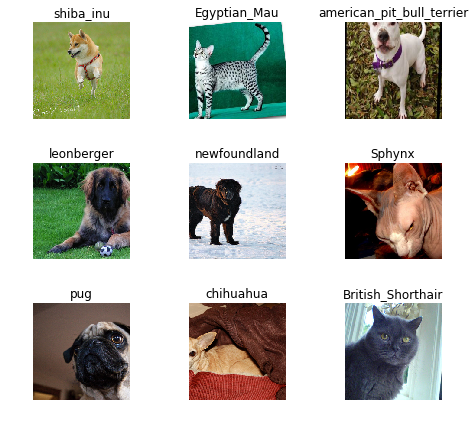

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 23710321.27it/s]


In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.384593,0.328204,0.097429,01:24
1,0.563002,0.274860,0.089986,01:24
2,0.346606,0.223527,0.071719,01:22
3,0.258432,0.210959,0.070365,01:23


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

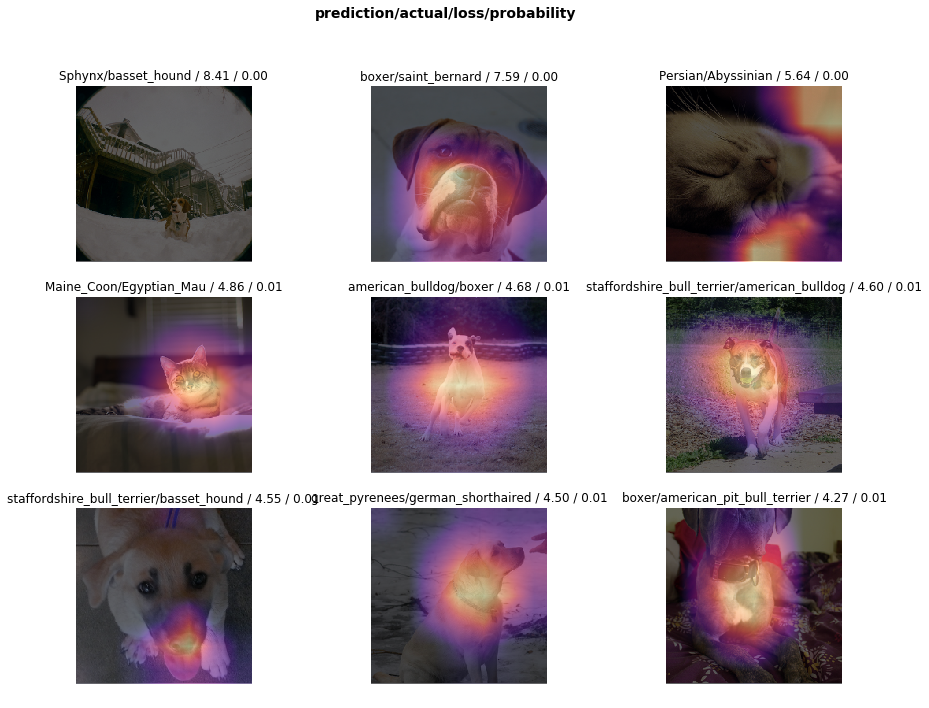

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
doc(interp.plot_top_losses)

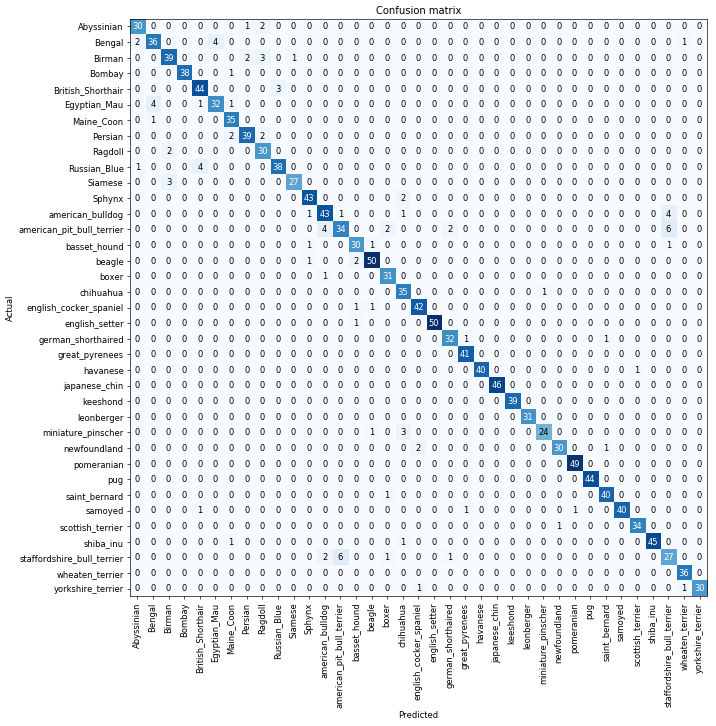

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Siamese', 'Birman', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Ragdoll', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Persian', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('american_pit_bull_terrier', 'german_shorthaired', 2),
 ('beagle', 'basset_hound', 2),
 ('newfoundland', 'english_cocker_spaniel', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.541563,0.364230,0.119756,01:24


In [0]:
learn.load('stage-1');

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


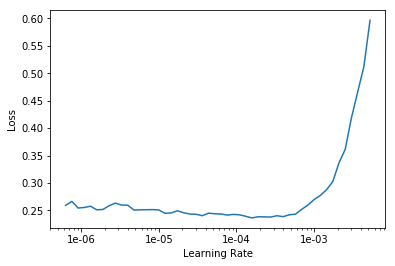

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.236346,0.199125,0.066306,01:23
1,0.201725,0.194554,0.061570,01:23


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [33]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:14<00:00, 7273064.03it/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


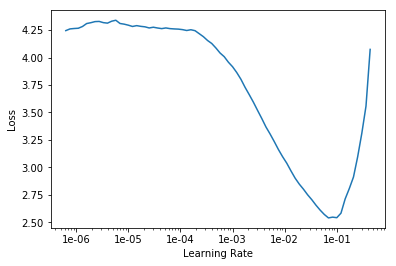

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.744251,0.288526,0.080514,02:09
1,0.439127,0.213985,0.073072,02:07
2,0.349639,0.200360,0.065629,02:07
3,0.272300,0.224801,0.074425,02:07
4,0.205539,0.186788,0.056157,02:07
5,0.152951,0.168575,0.053451,02:08
6,0.109775,0.161739,0.049391,02:07
7,0.094789,0.160859,0.051421,02:07


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [41]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.109125,0.164543,0.051421,02:19
1,0.084449,0.155862,0.048038,02:18
2,0.069294,0.156544,0.047361,02:18


If it doesn't, you can always go back to your previous model.

In [0]:
# Will not revert back to previous model, as the current one seems to have lower errors.
# learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [43]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('Persian', 'Ragdoll', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('keeshond', 'leonberger', 2),
 ('shiba_inu', 'miniature_pinscher', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Other data formats

In [44]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

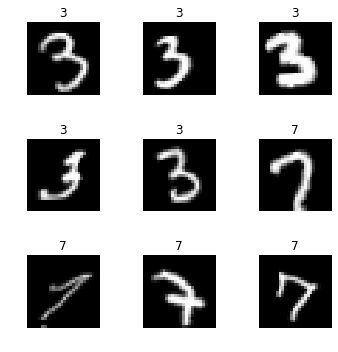

In [46]:
data.show_batch(rows=3, figsize=(5,5))

In [47]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 21047008.74it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.194337,0.119656,0.950932,00:17
1,0.103751,0.043767,0.983808,00:16


In [52]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

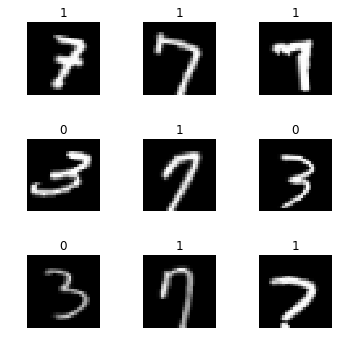

In [54]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [55]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [56]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [57]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [58]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [59]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [60]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

## Personal Project - Identifying Bronchitis
In this portion of the notebook I will use the dataset of lung scan images and identify if they are normal or suffer from bronchitis. 
For bronchitis, I will further identify its type - Viral or Bacterial. 

Data is stored in Google Drive in the **lesson1** folder under **fastai-v3**. 
* Scans of lungs not suffering from bronchitis have labels beginning with **NORMAL_**.
* Scans of lungs suffering from bacterial bronchitis have labels beginning with **bacteria_**.
* Scans of lungs suffering from viral bronchitis have labels beginning with **virus_**.

In [71]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
path_scans = Path(base_dir + 'data/lesson1/train')
fnames = get_image_files(path_scans)
fnames[:5]

Mounted at /content/gdrive


[PosixPath('/content/gdrive/My Drive/fastai-v3/data/lesson1/train/bacteria_1.jpeg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/lesson1/train/bacteria_3.jpeg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/lesson1/train/bacteria_2.jpeg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/lesson1/train/bacteria_4.jpeg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/lesson1/train/bacteria_11.jpeg')]

Using the same random seed and regex expression from previous portion of the notebook to remove the trailing numbers from the scans to get the labels.

In [0]:
np.random.seed(2)
pat1 = r'/([^/]+)_\d+.jpeg$'

Now using the **Image Data Bunch** object type from fast.ai to store all the scans.
**bs** size will be the same as we will first use **Resnet34**.

In [0]:
scans = ImageDataBunch.from_name_re(path_scans, fnames, pat1, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Checking if the scans are uploded correctly visually.

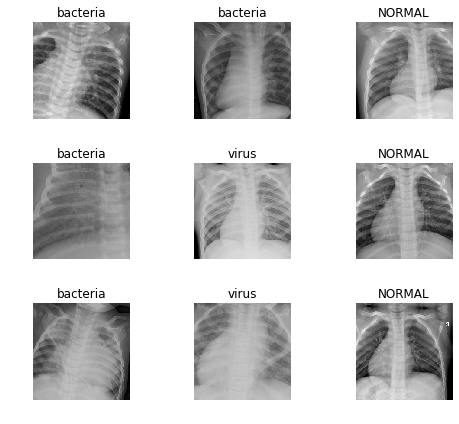

In [76]:
scans.show_batch(rows=3, figsize=(7,6))

There are just 3 classes: virus, bacteria and NORMAL.

In [77]:
print(scans.classes)
len(scans.classes),scans.c

['NORMAL', 'bacteria', 'virus']


(3, 3)

Now we will create the model (cnn_learner). In this case, we will call it **prognosis**, as we are trying to provide a prognosis of bronchitis. 

We will use the resnet34 weights for this learner.

In [0]:
prognosis = cnn_learner(scans, models.resnet34, metrics=error_rate)

Now we will **train** the model on the dataset. 

Because distinguishing between scans is much more difficult than ordinary pictures, we **do not** get a good error rate even after using **12 epochs**.

In [81]:
prognosis.fit_one_cycle(12)

epoch,train_loss,valid_loss,error_rate,time
0,0.509949,0.508240,0.158228,00:31
1,0.504288,0.505911,0.164557,00:31
2,0.484321,0.513890,0.189873,00:31
3,0.467478,0.542944,0.183544,00:31
4,0.463416,0.517182,0.189873,00:31
5,0.450076,0.514208,0.170886,00:31
6,0.439279,0.549006,0.183544,00:31
7,0.441330,0.516384,0.164557,00:31
8,0.421332,0.515083,0.170886,00:31
9,0.404163,0.508192,0.151899,00:31


Just saving the learner as **prog-1**.

In [0]:
prognosis.save('prog-1')

Let's check the interpretation for the bronchitis **prognosis**.

Because we have just 3 classes and because the Learner did not do very well in its predictions, we will get all combinations of the 3 classes in our confusion matrix.

In [84]:
interpretation = ClassificationInterpretation.from_learner(prognosis)

loss,idx = interpretation.top_losses()

len(scans.valid_ds)==len(loss)==len(idx)

True

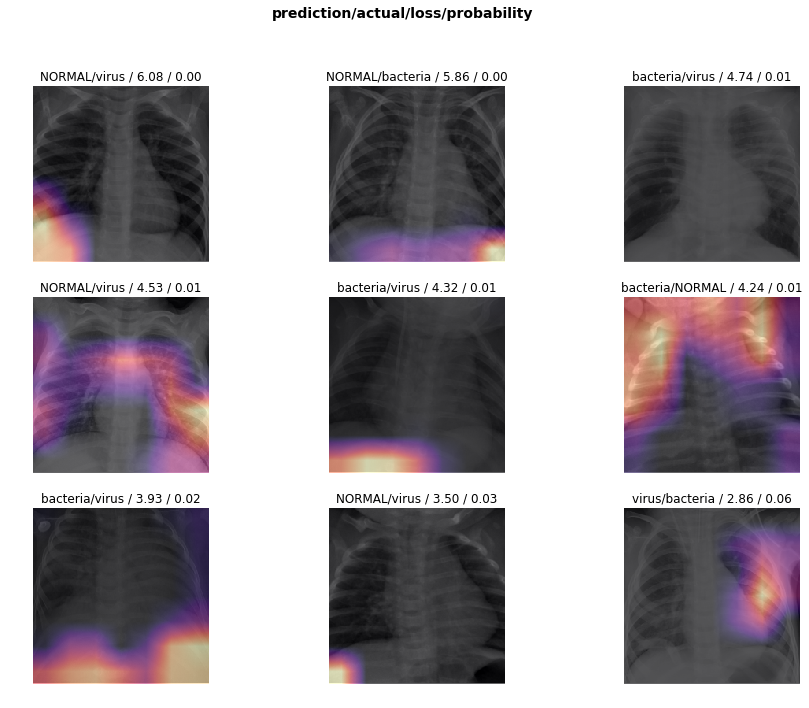

In [85]:
interpretation.plot_top_losses(9, figsize=(15,11))

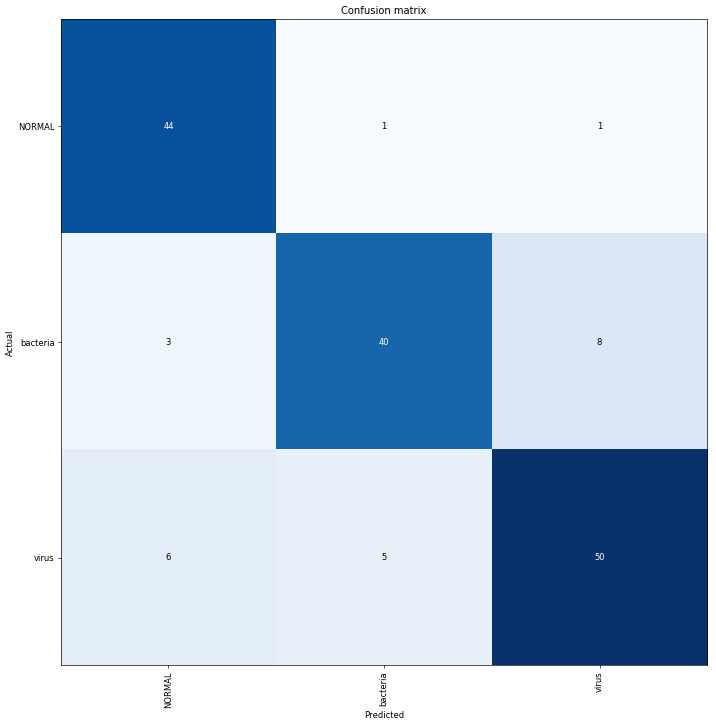

In [86]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can see from the **Confusion Matrix** above that the model actually did really well. The reason why we are getting such large **Error Rates** is because our dataset is not very large. So, even a small number of mis-classifications lead to large error rates.

In [87]:
interpretation.most_confused(min_val=2)

[('bacteria', 'virus', 8),
 ('virus', 'NORMAL', 6),
 ('virus', 'bacteria', 5),
 ('bacteria', 'NORMAL', 3)]

From the above **most_confused** data, we can see that the model was making the most mistakes between **bacteria** and **virus** bronchitis and vice-versa. 

This is understandable as the coloration in the scans for bronchitis is very difficult to distinguish between.

### Training with Resnet-50
After training with Resnet-34 weights, we will try to train the model with Resnet-50 weights.

Before doing so, let's change the Image Bunch dataset to have reduced **Batch-size** and **Size**.

In [0]:
scans2 = ImageDataBunch.from_name_re(path_scans, fnames, pat1, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

Now we will implement the **Resnet-50** weights in our **Learner**.

In [0]:
prognosis2 = cnn_learner(scans2, models.resnet50, metrics=error_rate)

Before fitting the model, we can find its **optimum learning rate** and plot it.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


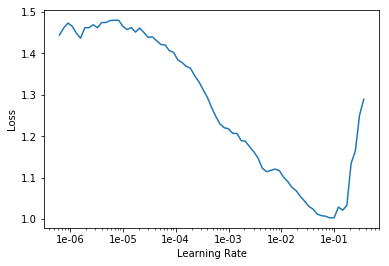

In [90]:
prognosis2.lr_find()
prognosis2.recorder.plot()

The steep decline in the **Loss** after **LR** of **1e-04** is suspicious. We will avoid using anything beyond that as our LR limit in the fitting process.

Now that we have created the Learner and found its optimum learning rate, we will train (fit) it on the Scans Image Bunch.

We will specifically limit the LR between 1e-06 and 1e-05 for this fitting as it is the most optimal. 

I noticed that increasing the number of epochs (3 to 14) **does not** really decrease the error rate.

In [93]:
prognosis2.unfreeze()
prognosis2.fit_one_cycle(14, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.788843,0.626711,0.278481,00:42
1,0.729036,0.615718,0.278481,00:42
2,0.746650,0.636276,0.291139,00:43
3,0.773466,0.636086,0.259494,00:42
4,0.746765,0.613223,0.278481,00:42
5,0.728921,0.598731,0.240506,00:42
6,0.720854,0.572223,0.227848,00:42
7,0.698611,0.591410,0.240506,00:43
8,0.693221,0.566934,0.221519,00:42
9,0.675009,0.601043,0.240506,00:42


Let's see the Confusion Matrix for this customized deep-learning operation.

In [0]:
interpretation2 = ClassificationInterpretation.from_learner(prognosis2)

In [95]:
interpretation2.most_confused(min_val=2)

[('virus', 'bacteria', 10),
 ('virus', 'NORMAL', 9),
 ('bacteria', 'NORMAL', 7),
 ('bacteria', 'virus', 5)]

Somehow the Confusion Matrix of **Resnet-50** is somehow **worse** than that of **Resnet-34**. Maybe it is because of the limits we placed on the Learning Rate.

We will now save this model and use a different model which does not have those limits.

In [0]:
prognosis2.save('stage-1-50-custom')

After Freezing this portion of the Learner, we can now make changes to it.

I will unfreeze the Learner and make it learn automatically without limiting its Learning Rate.

In [0]:
prognosis2.unfreeze()

In [98]:
prognosis2.fit_one_cycle(14)

epoch,train_loss,valid_loss,error_rate,time
0,0.586907,0.575099,0.196203,00:41
1,0.521697,0.841216,0.221519,00:42
2,0.522519,0.545475,0.132911,00:41
3,0.508948,0.699874,0.164557,00:42
4,0.477075,0.687234,0.208861,00:42
5,0.420720,0.290203,0.094937,00:42
6,0.335791,0.392785,0.113924,00:42
7,0.280690,0.375962,0.088608,00:42
8,0.256284,0.359809,0.120253,00:43
9,0.231919,0.261501,0.063291,00:42


We see **much better results** in the **automatic training** as compared to the customized Resnet-50 and any of the Resnet-34 models.

Let's get a Confusion Matrix and Interpretation of this latest Model.

In [99]:
interpretation2 = ClassificationInterpretation.from_learner(prognosis2)

loss,idx = interpretation2.top_losses()

len(scans.valid_ds)==len(loss)==len(idx)

True

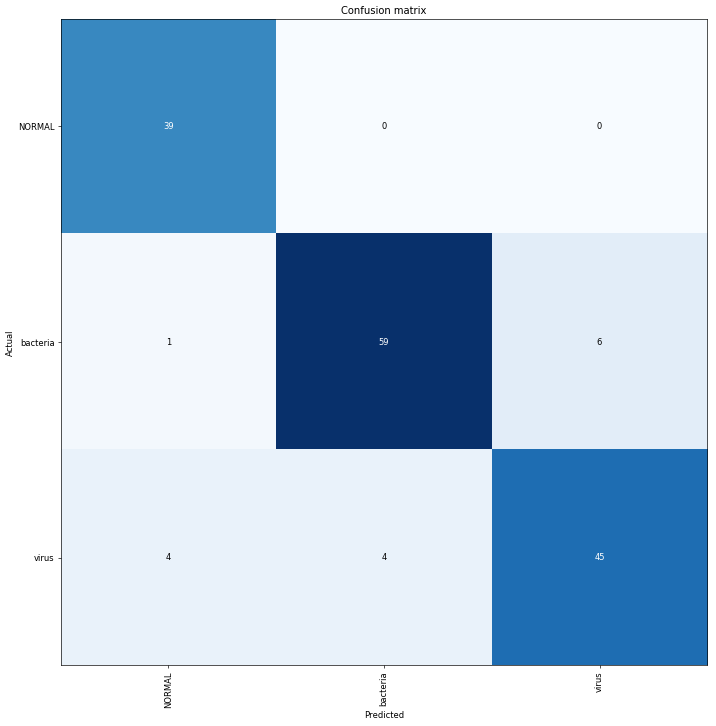

In [100]:
interpretation2.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [101]:
interpretation2.most_confused(min_val=2)

[('bacteria', 'virus', 6), ('virus', 'NORMAL', 4), ('virus', 'bacteria', 4)]

The **Interpretation** and **Confusion Matrix** further prove that the **Resnet-50** Model trained without limiting its LR is the **most successful** of all the Models.

We see that the number of mis-classifications has been reduced in the Confusion Matrix.

Also, most of the mis-classifications have been limited to the bacteria-virus classes, which is understandable.

## Conclusion
1. Having higher Resnet weights in general gives more accurate predictions.
2. Based on the Image dataset type, size and classification, the most optimal configuration of CNN Model should be chosen.
3. Although we can try limiting Learning Rate (LR) to get better predictions, but this depends on the data too. It is best practice to try out different LRs (automatic as well), epochs and Resnet models before making the final decision.